<a href="https://colab.research.google.com/github/marcus-v-rodrigues/ml-project/blob/main/Trabalho_Pr%C3%A1tico_1_%E2%80%93_Tarefas_Preditivas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Marcus Vinícius Santos Rodrigues - 11218862

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
import seaborn as sns

In [26]:
# Lendo os dados de espectros e metadados
spectra = pd.read_csv('pure_spectra_matrix.csv', header=None, sep=';')
metadata = pd.read_csv('pure_spectra_metadata.csv', sep=';')

In [27]:
# Criando um transformador personalizado para a transformação logarítmica
log_transformer = FunctionTransformer(lambda x: np.log(x + 1)) # Adicionando 1 para evitar log de zero

In [28]:
# Pipeline de pré-processamento
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Tratamento de valores ausentes
    ('log_transformer', log_transformer),           # Aplicação da transformação logarítmica
    ('scaler', StandardScaler()),                   # Normalização dos dados
    ('min_max_scaler', MinMaxScaler())              # Escalonamento para o intervalo [0, 1]
])

In [29]:
# Aplicando o pipeline de pré-processamento nos dados
X_preprocessed = preprocessing_pipeline.fit_transform(spectra)

In [30]:
# Rebalanceamento dos dados
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_preprocessed, metadata['Species'])

In [31]:
# Aplicar PCA para reduzir a dimensionalidade
pca = PCA(n_components=0.95)  # Manter 95% da variância explicada
X_pca = pca.fit_transform(X_resampled)

In [32]:
# Informações de saída
print(f'Dimensões originais: {spectra.shape[1]}, Dimensões após PCA: {X_pca.shape[1]}')
print(f'Distribuição de classes após rebalanceamento:\n{pd.Series(y_resampled).value_counts()}')

Dimensões originais: 1300, Dimensões após PCA: 295
Distribuição de classes após rebalanceamento:
Species
RTO.TQH    60
BUT.YZE    60
NYV.VCE    60
BUT.TRH    60
AUG.AEX    60
EMD.WXC    60
QBG.CRP    60
AUG.HSS    60
RTO.JFR    60
JNH.ZIJ    60
VVJ.KWJ    60
NYV.XSY    60
QWP.LRO    60
EMD.FZO    60
QWP.DRH    60
BUT.BIK    60
BUT.DNW    60
JNH.FLH    60
VVJ.KSF    60
QBG.KGI    60
Name: count, dtype: int64


In [43]:
# Renomeando variáveis
X = X_pca
y = y_resampled

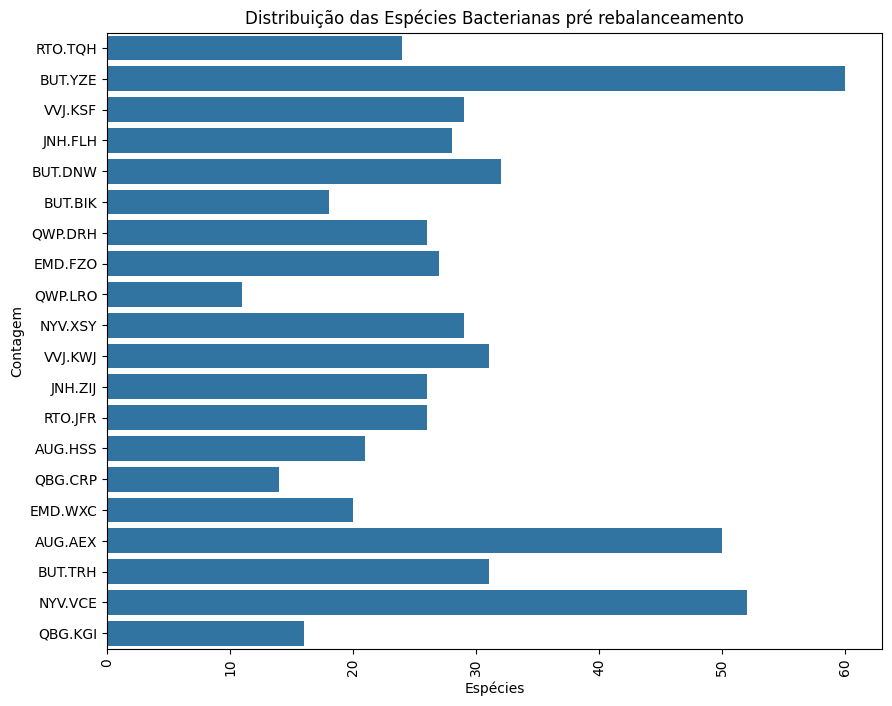

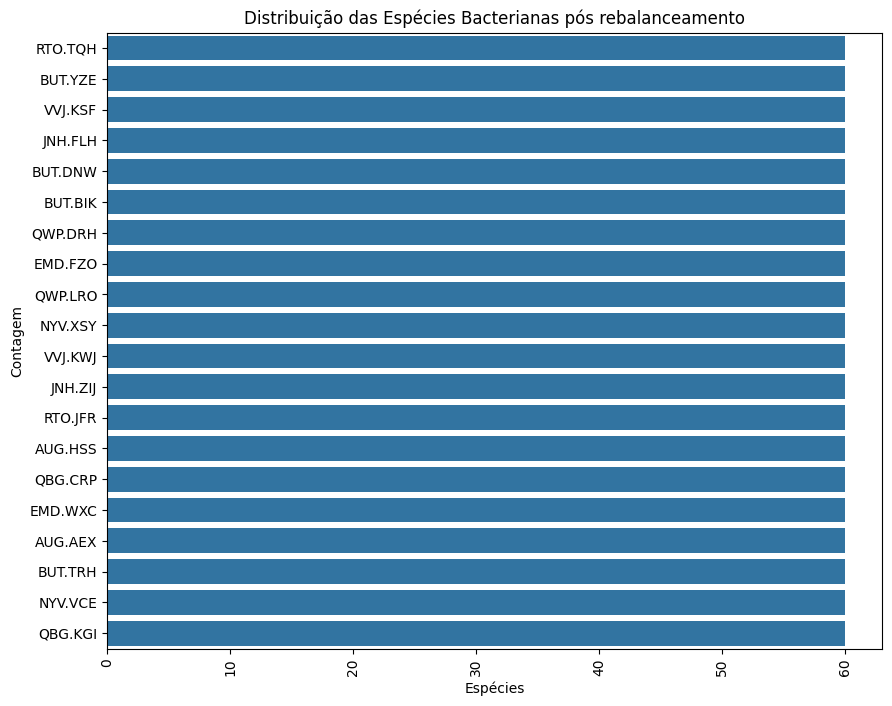

In [34]:
# Visualização da distribuição das classes
plt.figure(figsize=(10, 8))
sns.countplot(y=metadata['Species'])
plt.title('Distribuição das Espécies Bacterianas pré rebalanceamento')
plt.xlabel('Espécies')
plt.ylabel('Contagem')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 8))
sns.countplot(y=y)
plt.title('Distribuição das Espécies Bacterianas pós rebalanceamento')
plt.xlabel('Espécies')
plt.ylabel('Contagem')
plt.xticks(rotation=90)
plt.show()

In [35]:
pipeline = make_pipeline(RandomForestClassifier(random_state=42))

In [36]:
# Definição de cross-validation
cv = StratifiedKFold(n_splits=10)

In [37]:
# Avaliação do modelo com cross-validation
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
print("Acurácia média com 10-fold CV:", np.mean(scores))
print("Desvio padrão da acurácia:", np.std(scores))

Acurácia média com 10-fold CV: 0.9775
Desvio padrão da acurácia: 0.021098314835286944


In [38]:
# Configuração do RandomizedSearchCV para otimização de hiperparâmetros
param_distributions = {
    'randomforestclassifier__n_estimators': [100, 200, 300],  # Número de árvores na floresta
    'randomforestclassifier__max_features': ['sqrt', 'log2'],  # Número de características a considerar ao procurar a melhor divisão
    'randomforestclassifier__max_depth': [None, 10, 20, 30],  # Profundidade máxima das árvores. None significa que as árvores são expandidas até todas as folhas serem puras ou até que todas as folhas contenham menos do que min_samples_split amostras.
    'randomforestclassifier__min_samples_split': [2, 5, 10],  # Número mínimo de amostras necessárias para dividir um nó interno
    'randomforestclassifier__min_samples_leaf': [1, 2, 4]  # Número mínimo de amostras necessárias para estar em um nó folha
}

In [39]:
random_search = RandomizedSearchCV(
    pipeline,  # Pipeline que inclui o pré-processamento e o modelo
    param_distributions=param_distributions,  # Dicionário de parâmetros a ser testado
    n_iter=10,  # Número de combinações de parâmetros a ser testadas
    cv=cv,  # Objeto de validação cruzada
    scoring='accuracy',  # Métrica de avaliação para otimizar
    verbose=1,  # Controle o nível de mensagens: quanto maior, mais mensagens são mostradas
    n_jobs=-1,  # Número de jobs a correr em paralelo (-1 usa todos os processadores)
    random_state=42  # Semente para a reprodutibilidade dos resultados
)
random_search.fit(X, y)
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score de acurácia:", random_search.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Melhores parâmetros: {'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 30}
Melhor score de acurácia: 0.9841666666666666


In [40]:
# Configuração detalhada do modelo final e geração do relatório de classificação
predicted = cross_val_predict(random_search.best_estimator_, X, y, cv=cv)
report = classification_report(y, predicted)
print("Relatório de classificação:\n", report)

Relatório de classificação:
               precision    recall  f1-score   support

     AUG.AEX       1.00      1.00      1.00        60
     AUG.HSS       1.00      1.00      1.00        60
     BUT.BIK       0.98      0.98      0.98        60
     BUT.DNW       0.98      0.97      0.97        60
     BUT.TRH       0.97      0.98      0.98        60
     BUT.YZE       0.89      0.92      0.90        60
     EMD.FZO       1.00      1.00      1.00        60
     EMD.WXC       1.00      1.00      1.00        60
     JNH.FLH       1.00      0.97      0.98        60
     JNH.ZIJ       0.98      1.00      0.99        60
     NYV.VCE       0.96      0.87      0.91        60
     NYV.XSY       0.92      1.00      0.96        60
     QBG.CRP       1.00      1.00      1.00        60
     QBG.KGI       1.00      1.00      1.00        60
     QWP.DRH       1.00      1.00      1.00        60
     QWP.LRO       1.00      1.00      1.00        60
     RTO.JFR       1.00      1.00      1.00        6

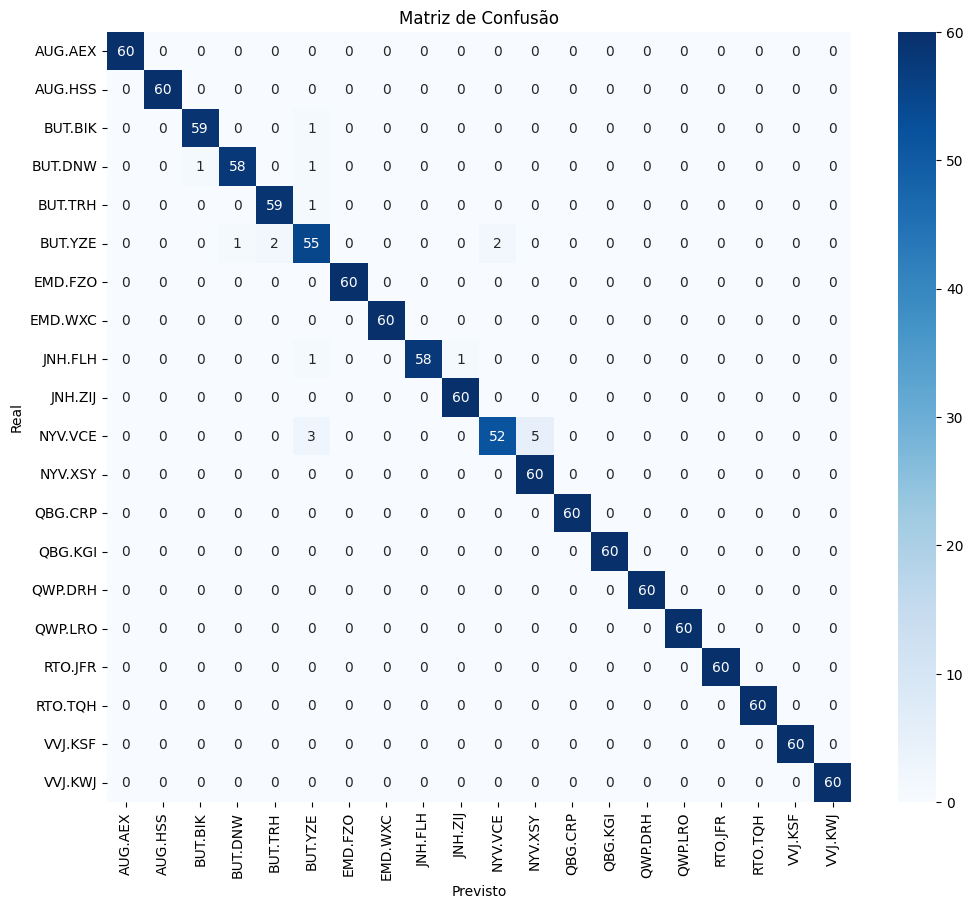

In [41]:
# Matriz de confusão
cm = confusion_matrix(y, predicted)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()